Inspired by Mahler (1990) and the use of baseball win percentages as an illustrative example of how insurance experience ratemaking works, I wanted to provide an implementation of the exponential smoothing approach mentioned. The dataset contains data of the annual season loss percentages for 8 teams from 1901 to 1960. The notion is that in the same way you would use the past history of an insured to predict their forward policy losses, you can use the history of a team's performance to predict their performance going forward. Compared to a real-life insurance example, this dataset is simple because it has the same number of individuals throughout and they are all observed at every time step.

The paper already does a good job covering many possible approaches to this problem. It notes that first we want to pick a method that puts heavier weight on more recent observations because of the inherent non-stationarity of the underlying process. Including far-away past years may actually worsen your estimate because the environment going forward may have shifted substantially. The author discusses multiple solutions: the estimate of every team is the grand average of the data, use the most recent years loss percentage for each team as the prediction, weighting together the most recent year and the overall average, etcetera. Here, however, I'm going to focus on what is to me the most elegant solution, which is exponential smoothing.

First I'll cover the exponential smoothing approach on the whole dataset as given, and then I'll extend it to the more complex case of having differing numbers and placements of observations for each team through time.

# Properties of the Data

The first question to ask is if there is any value in the first place to using previous observations of each team to predict their future loss rate. The paper answers the more basic question of whether the teams have meaningfully different overall loss rates compared to each other, so I'll take that as given here. To answer the temporal question, we can look at the autocorrelation of the observations of each team.

In [1]:
import polars as pl
import polars.selectors as cs
import statsmodels.api as sm
import matplotlib.pyplot as plt
import cmdstanpy as stan
import arviz as az
import numpy as np
from scipy import stats

rng = np.random.default_rng()

/Users/erikdains/Programming/PythonBlogProjects/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pl.read_csv("..//data//nl-data.csv").sort("Year")

In [3]:
df

Year,NL1,NL2,NL3,NL4,NL5,NL6,NL7,NL8
i64,f64,f64,f64,f64,f64,f64,f64,f64
1901,0.5,0.419,0.619,0.626,0.62,0.407,0.353,0.457
1902,0.467,0.457,0.504,0.5,0.647,0.591,0.259,0.582
1903,0.58,0.485,0.406,0.468,0.396,0.637,0.35,0.686
1904,0.641,0.634,0.392,0.425,0.307,0.658,0.431,0.513
1905,0.669,0.684,0.399,0.484,0.314,0.454,0.373,0.623
…,…,…,…,…,…,…,…,…
1956,0.396,0.403,0.61,0.409,0.565,0.539,0.571,0.506
1957,0.455,0.383,0.597,0.481,0.552,0.5,0.597,0.435
1958,0.539,0.403,0.532,0.506,0.481,0.552,0.455,0.532


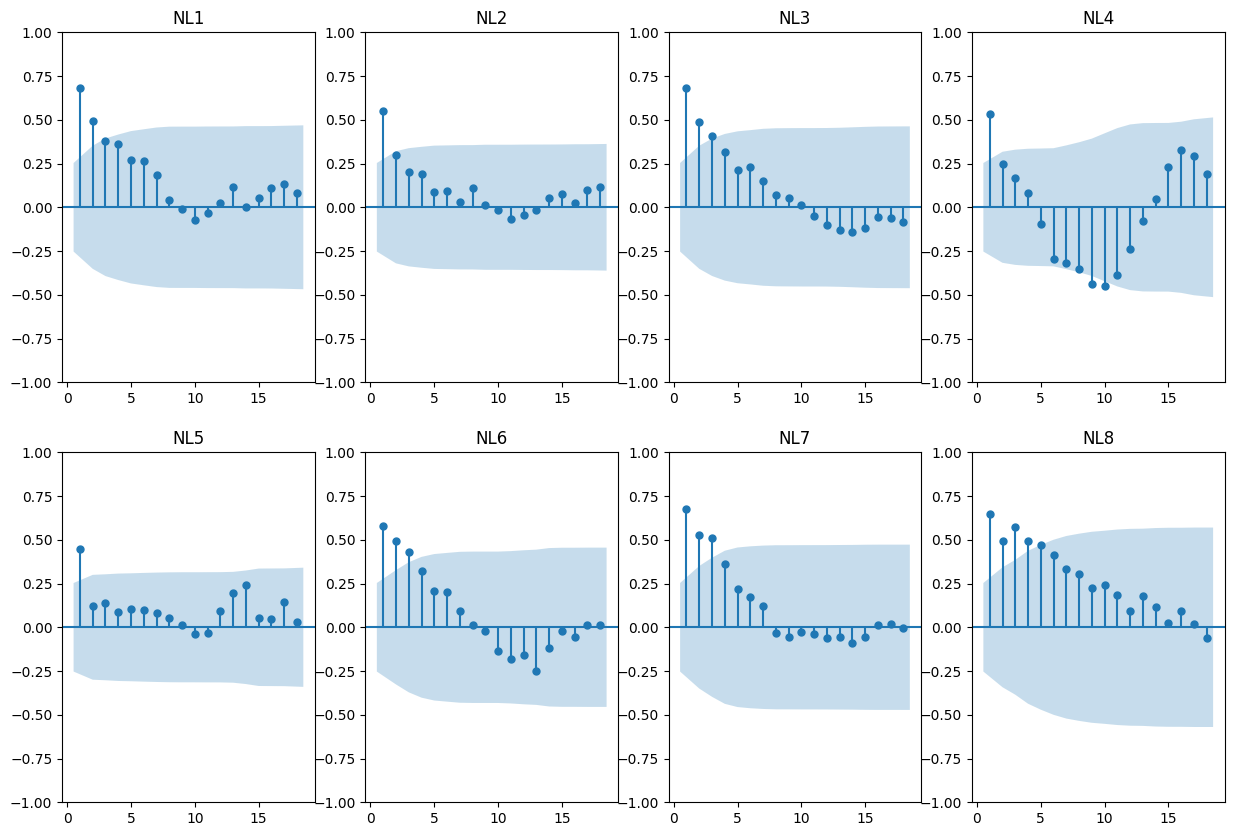

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(15, 10))
for i in range(8):
    ax = axes.ravel()[i]
    sm.graphics.tsa.plot_acf(df[f"NL{i+1}"], ax=ax, zero=False)
    ax.set_title(f"NL{i+1}")

The light blue areas are the 95% confidence intervals for the autocorrelations. We can obviously see significant autocorrelations for at least one lag for every team, meaning there is indeed valuable information to be gained by using past years data to make predictions.

# Homogenous Observations Case

First, I'll cover the original and more simple case where we observe loss rates for every team in every year. A basic univariate exponential smoothing model looks like this:

$$
\mu_t = \alpha y_{t-1} + (1 - \alpha) \mu_{t-1}
$$

Our estimate for each time period $t$ is $\mu_t$ and this is taken to be a weighted sum of the actually observed value from the last time period and our previous smoothed estimator. This does mean that you have to handle setting the first smoothed value $\mu_0$, which I'm letting be a free parameter here.

The model here extends this simply by assuming this univariate form for each team separately:

$$
\mu_{i, t} = \alpha y_{i, t-1} + (1 - \alpha) \mu_{i, t-1}
$$

where $i$ indexes over each team. Note that the smoothing parameter, $\alpha$, is assumed to be the same for each team, although you could easily extend this to the case where it is allowed to vary.

In probabilistic terms, here is the full set of equations with priors:

$$
k \sim \text{Exponential}(1) \\
\alpha \sim \text{Beta}(2, 2) \\
\mu_{i, 0} \sim \text{Beta}(2, 2) \\

\mu_{i, t} = \alpha y_{i, t-1} + (1 - \alpha) \mu_{i, t-1} \\
y_{i, t} \sim \text{Beta}(\mu = \mu_{i, t}, \sigma^2 = k)
$$

where $y_{i, t}$ is the loss rate observation for team $i$ at time $t$.

I'm assuming that the prior for the first smoothed value and the smoothing strength parameter are $\text{Beta}(2, 2)$ distributed, which looks like this:

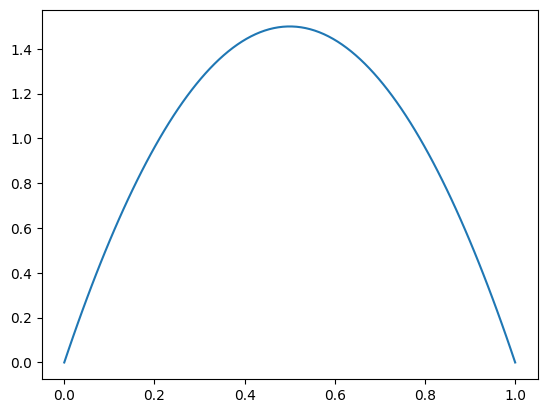

In [5]:
xs = np.linspace(0, 1, 100)
plt.plot(xs, stats.beta.pdf(xs, 2, 2))

Here, $\frac{1}{2}$ is the mode. By assuming this prior we are saying that it's unlikely that either of these quantities assume very extreme values, which is reasonable in this case. For the initial smoothing value, we are saying a 50/50 win/loss performance is the most probable, and values close to 0 or 1 are unlikely, which is a sensible prior assumption. For the smoothing strength parameter we are assuming that the case where we evenly weight the last observed value and the last smoothed value is the most probable, and its unlikely that we want to put full weight on either one or the other, which, again, is a sensible prior assumption. I've chosen an exponential distribution for the outcome variance parameter because it's the maximum entropy distribution for random variables bounded below by zero. In this case, the parameter for this prior variable has little effect on the results.

This can all be encoded in Stan as follows:

```
data {
    int N; // Number of teams
    int T; // Number of observations
    array[N] vector[T] L; // Observation vector for each team
}
parameters {
    real<lower=0> k;
    real<lower=0, upper=1> alpha;
    real<lower=0, upper=1> mu_zero;
}
transformed parameters {
    array[N] vector[T] mu;
    for (i in 1:N) {
        mu[i][1] = mu_zero;
    }
    for (t in 2:T) {
        for (i in 1:N) {
            mu[i][t] = alpha * L[i][t-1] + (1 - alpha) * mu[i][t-1];
        }
    }
}
model {
    k ~ exponential(1);
    alpha ~ beta(2, 2);
    mu_zero ~ beta(2, 2);
    for (t in 1:T) {
        for (i in 1:N) {
            L[i][t] ~ beta_proportion(mu[i][t], k);
        }
    }
}
generated quantities {
    array[N] vector[T] L_hat;
    for (t in 1:T) {
        for (i in 1:N) {
            L_hat[i][t] = beta_proportion_rng(mu[i][t], k); // Posterior predictive
        }
    }
}
```

In [34]:
# If error: PCH file uses an older PCH format that is no longer supported
# Then: stan.rebuild_cmdstan()
model = stan.CmdStanModel(stan_file="../experience_rating/model.stan")

14:36:23 - cmdstanpy - INFO - compiling stan file /Users/erikdains/Programming/PythonBlogProjects/experience_rating/model.stan to exe file /Users/erikdains/Programming/PythonBlogProjects/experience_rating/model
14:36:28 - cmdstanpy - INFO - compiled model executable: /Users/erikdains/Programming/PythonBlogProjects/experience_rating/model


In [35]:
data = {"N": 8, "T": len(df), "L": [df[f"NL{i}"].to_list() for i in range(1, 9)]}

fit = model.sample(data=data)

14:36:29 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status





chain 1 |█▎        | 00:00 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |███▏      | 00:00 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |█████     | 00:00 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |██████▊   | 00:00 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |████████▏ | 00:00 Iteration: 1500 / 2000 [ 75%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


14:36:30 - cmdstanpy - INFO - CmdStan done processing.
14:36:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_proportion_lpdf: Location parameter is 1, but must be less than 1.000000 (in '/Users/erikdains/Programming/PythonBlogProjects/experience_rating/model.stan', line 28, column 12 to column 51)
Exception: beta_proportion_lpdf: Precision parameter is inf, but must be positive finite! (in '/Users/erikdains/Programming/PythonBlogProjects/experience_rating/model.stan', line 28, column 12 to column 51)
Exception: beta_proportion_lpdf: Precision parameter is inf, but must be positive finite! (in '/Users/erikdains/Programming/PythonBlogProjects/experience_rating/model.stan', line 28, column 12 to column 51)
Exception: beta_proportion_lpdf: Location parameter is 0, but must be positive! (in '/Users/erikdains/Programming/PythonBlogProjects/experience_rating/model.stan', line 28, column 12 to column 51)
Consider re-running with show_console=True if the above outpu

Fitting this, we can check the summary statistic for our chain and convergence statistics:

In [36]:
fit.summary()["R_hat"].describe()

count    964.000000
mean       0.999956
std        0.000440
min        0.999100
25%        0.999736
50%        0.999888
75%        1.000110
max        1.002550
Name: R_hat, dtype: float64

In [37]:
print(fit.diagnose())

Processing csv files: /var/folders/zs/49z19b7n08s7f_s0x1d2j6gr0000gn/T/tmpe_4z79qx/modeliavojzkq/model-20241031143629_1.csv, /var/folders/zs/49z19b7n08s7f_s0x1d2j6gr0000gn/T/tmpe_4z79qx/modeliavojzkq/model-20241031143629_2.csv, /var/folders/zs/49z19b7n08s7f_s0x1d2j6gr0000gn/T/tmpe_4z79qx/modeliavojzkq/model-20241031143629_3.csv, /var/folders/zs/49z19b7n08s7f_s0x1d2j6gr0000gn/T/tmpe_4z79qx/modeliavojzkq/model-20241031143629_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



Everything looks normal here, let's look at the posterior distribution of our parameters:

array([[<Axes: title={'center': 'k'}>, <Axes: title={'center': 'k'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'mu_zero'}>,
        <Axes: title={'center': 'mu_zero'}>]], dtype=object)

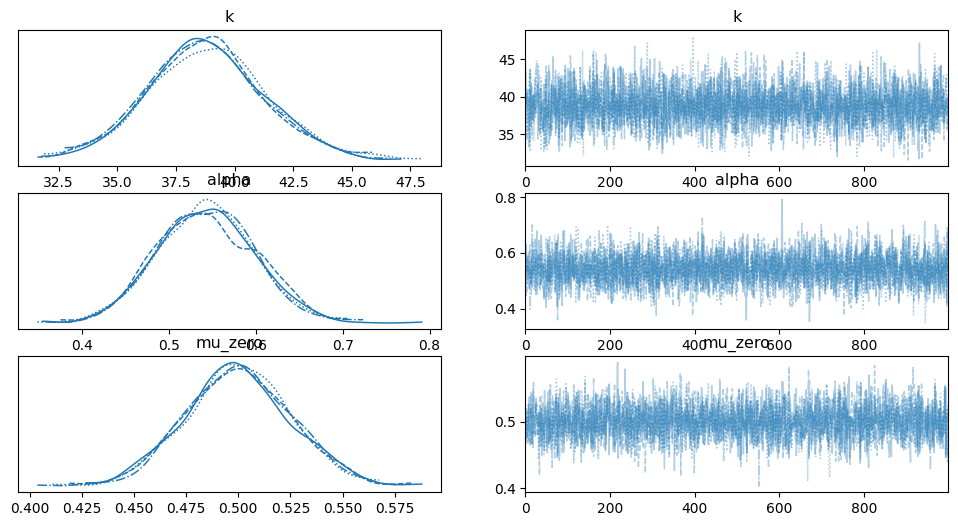

In [40]:
idata = az.from_cmdstanpy(
    fit,
    posterior_predictive="L_hat",
    observed_data={"L": [df[f"NL{i}"].to_list() for i in range(1, 9)]},
)
az.plot_trace(idata, var_names=["k", "alpha", "mu_zero"])

Again, this looks like healthy convergence.

Now we can look at the actually fit of the model. I'm not going to do a full-blown analysis here because this post is mainly meant to be a proof-of-concept, but we can make some general observations. First, let's look at the observed values and the smoothed values, $\mu$, for a given team:

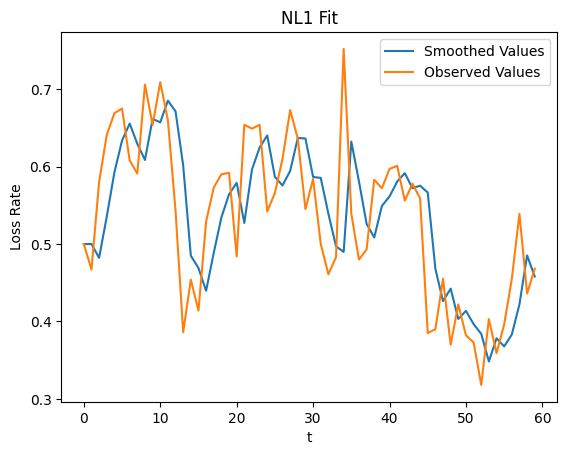

In [44]:
mu = az.extract(idata, var_names=["mu"])

plt.plot(mu[0, :, :].mean(axis=1))
plt.plot(df["NL1"])
plt.xlabel("t")
plt.ylabel("Loss Rate")
plt.title("NL1 Fit")
plt.legend(["Smoothed Values", "Observed Values"])

We can see that the smoothed values are indeed capturing the behavior of the observed values.

Next we can look at a posterior predictive plot to see how closely our distributional assumptions match the observed distribution of the data across all the teams:

<Axes: xlabel='L / L_hat'>

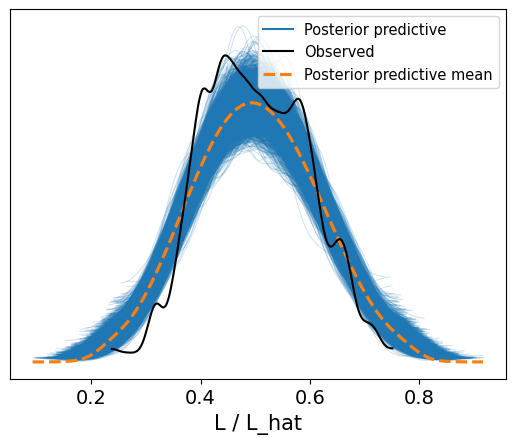

In [42]:
az.plot_ppc(
    idata,
    data_pairs={"L": "L_hat"}
)

We can see there is a fair bit of noise in the observed data, and maybe one could argue there is less kurtosis in the observed data than our model assumes, but we aren't too far off distributionally here. I imagine this could be fixed by changing the model to have a variance term that varies by team or maybe even over time. In the model present the variance is assumed to be constant for all teams and for all time periods.

Next, we can look at the implied weights on lagged data points given from the $\alpha$ parameter. Our model for $\mu$ is again defined as:
$$
\mu_{i, t} = \alpha y_{i, t-1} + (1 - \alpha) \mu_{i, t-1}
$$
So, we can continue to expand the autoregressive terms to get this purely in terms of the lagged $y$ values:
$$
\mu_{i, t} = \alpha y_{i, t-1} + (1 - \alpha) (\alpha y_{i, t-2} + (1 - \alpha) \mu_{i, t-2}) \\
= \alpha y_{i, t-1} + \alpha (1-\alpha) y_{i, t-2} + (1 - \alpha)^2 \mu_{i, t-2} \\
\vdots \\
= \alpha \sum_{i=1}^\infty (1 - \alpha)^{i-1} y_{i, t-i}
$$

We can adjust the index term on the sum to make it into a standard geometric series:
$$
\mu_{i, t }= \alpha \sum_{i=0}^\infty (1 - \alpha)^{i} y_{i, t-i+1}
$$

If we then assume that $y_{i,t} = 1$ for all $t$ for the sake of argument then we can see that this series converges to 
$$
\mu_{i, t} = \frac{\alpha}{1 - (1 - \alpha)} = \frac{\alpha}{\alpha} = 1
$$

So, our prediction is a weighted sum of infinitely many lagged observation values. We can plot these weights to see how quickly they decay:

Text(0.5, 1.0, 'Lagged Observation Weights')

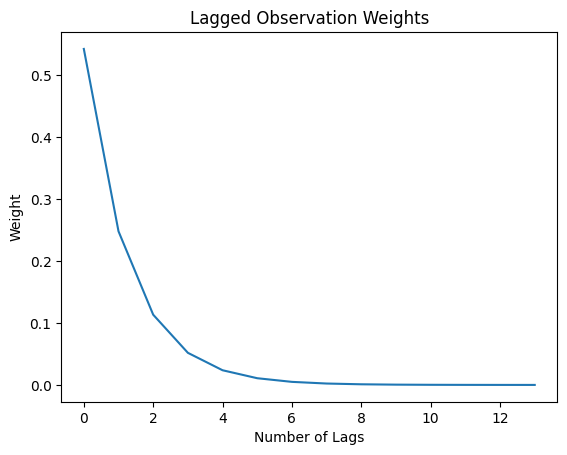

In [47]:
alpha = az.extract(idata, var_names=["alpha"]).mean().item()
L_coefs = [alpha * (1 - alpha) ** (i - 1) for i in range(1, 15)]
plt.plot(L_coefs)
plt.xlabel("Number of Lags")
plt.ylabel("Weight")
plt.title("Lagged Observation Weights")

So, we can see that a significant majority of the weight is being placed on observations in the 5 years. Since we know these weights also sum to 1, we can also see the cumulative total weight:

Text(0.5, 1.0, 'Cumulative Lagged Observation Weights')

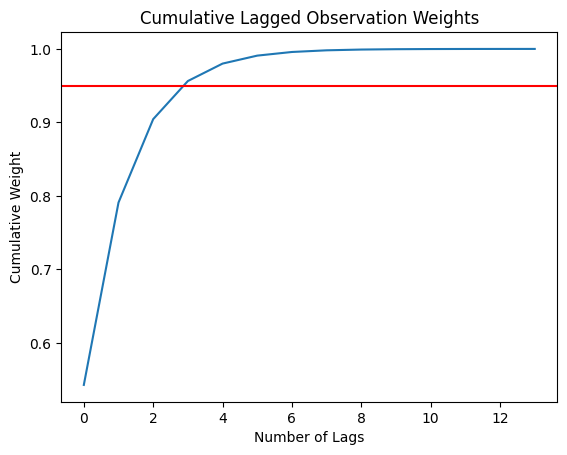

In [59]:
plt.plot(np.cumsum(L_coefs))
plt.axhline(0.95, color="red")
plt.xlabel("Number of Lags")
plt.ylabel("Cumulative Weight")
plt.title("Cumulative Lagged Observation Weights")

The red line is placed at 95% total weight, so we can see that 95% of the weight of our smoothed values come from data points in the last 3 seasons.

Lastly, let's see if we have controlled for the autocorrelation effect we saw in the original data by looking to see if there is any remaining patterns in the residuals:

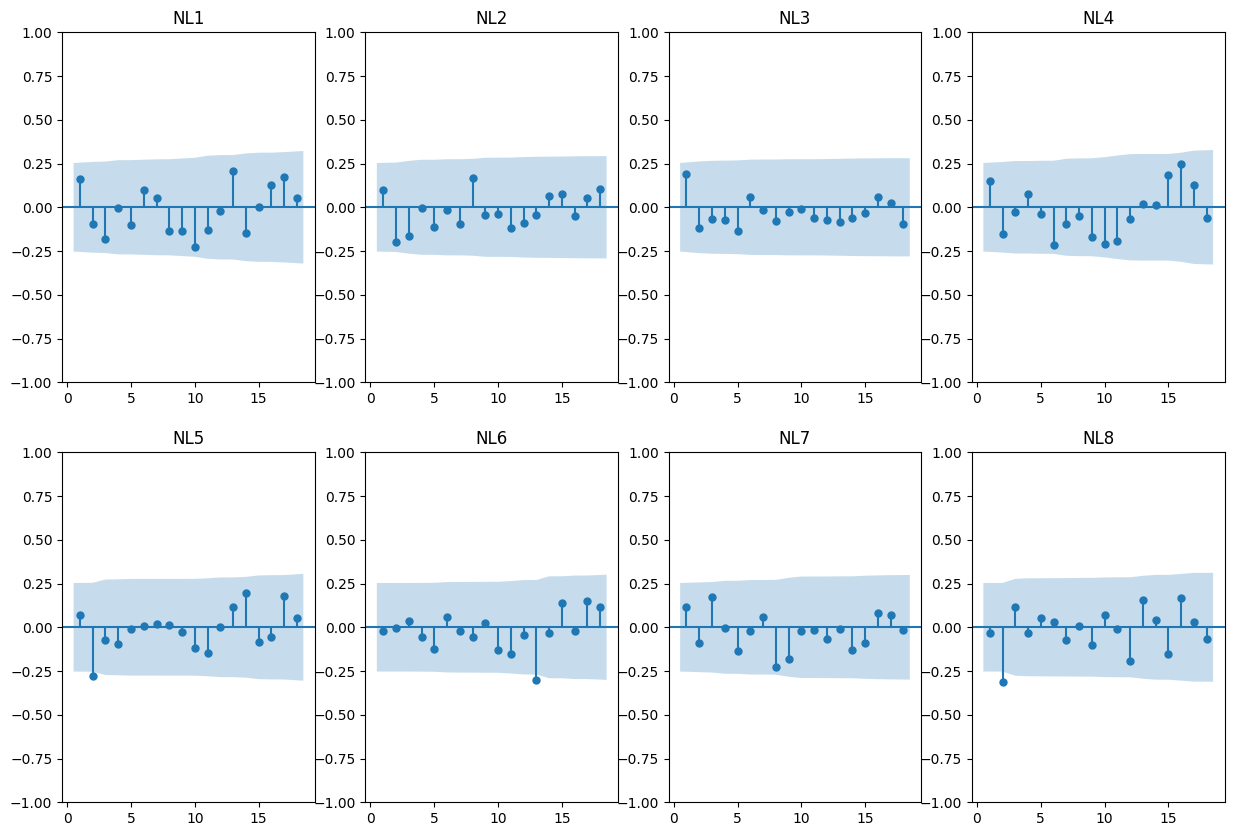

In [60]:
resids = df.select(cs.contains("NL")).to_numpy() - mu.mean(axis=2).values.T

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
for i in range(8):
    ax = axes.ravel()[i]
    sm.graphics.tsa.plot_acf(resids[:, i], ax=ax, zero=False)
    ax.set_title(f"NL{i+1}")

These autocorrelation plots now look much more random than they did originally, meaning we have captured much of the time-varying pattern present in the data.

# Heterogeneous Observations Case

Now that we've proven the concept of the model in the easy case, we can move on to the harder and more realistic case where we don't observe every individual at each time step. To accomplish this I'm setting the starting date of each teams observations to be random uniform from 1901 to 1920 and their ending dates to be random uniform from 1941 to 1960. I'm still making one simplifying observation which is that when do we observe a team we observe it every year for however long we do observe it for, which is not always true in real-life insurance datasets.

So, these are the new starting and ending dates for each team:

In [18]:
starting_years = rng.integers(1901, 1920, 8)
ending_years = rng.integers(1941, 1960, 8)

# Don't forget fencepost counting
pl.DataFrame(
    {
        "Team": df.select(cs.contains("NL")).columns,
        "StartingYear": starting_years,
        "EndingYear": ending_years,
    }
).with_columns(NumYears=(pl.col("EndingYear") - pl.col("StartingYear")) + 1)

Team,StartingYear,EndingYear,NumYears
str,i64,i64,i64
"""NL1""",1917,1949,33
"""NL2""",1918,1945,28
"""NL3""",1910,1958,49
"""NL4""",1903,1957,55
"""NL5""",1919,1954,36
"""NL6""",1919,1947,29
"""NL7""",1911,1955,45
"""NL8""",1907,1956,50


Now, the problem is that our observation vectors are of varying lengths, which means we cannot use the same data structure we used in the original model because it assume that each team's observation vector was the same length. Unfortunately, Stan does not currently support ragged arrays that would let us handle this natively, so we have to use some clever programming to make it work.

The solution is to append every team's observation vector into one single longer vector and separately keep track of what entries in this new vector belong to each team. So, first we create the observation vectors for each team, and then I've borrowed a nice function that creates a concatenated vector and returns the index of where each team's data ends:

In [19]:
df2 = df.with_columns(
    [
        pl.when(~pl.col("Year").is_between(start, end))
        .then(None)
        .otherwise(pl.col(f"NL{i+1}"))
        .alias(f"NL{i+1}")
        for i, (start, end) in enumerate(zip(starting_years, ending_years))
    ]
)

data_vectors = [df2[f"NL{i+1}"].drop_nulls() for i in range(0, 8)]

In [20]:
# From https://tonysyu.github.io/ragged-arrays.html
def stack_ragged(arrays):
    lens = [len(array) for array in arrays]
    idx = np.cumsum(lens)
    stacked = np.concatenate(arrays)
    return stacked, idx


stacked_data, data_idx = stack_ragged(data_vectors)

In [63]:
stacked_data.shape

(325,)

In [61]:
data_idx

array([ 33,  61, 110, 165, 201, 230, 275, 325])

So, team 1's data is from index 0 to 32, team 2's is from 33 to 60, and so on. Note that in Python the range slicing using a colon is left-side *inclusive* and right-side *exclusive*. So in the indexing array the endpoint for team 1 is 33 because you would use ```y[:33]``` to select it, but this selection would *not* include the value at index 33, it would stop at index 32. You could then use ```y[33:61]``` to select the data for team 2.

The next clever bit of programming comes in our Stan code to actually ingest these two structures. We are assuming the same model form, the only change we are making is the inconsistent observations, so, our model code now looks like this:

```
data {
    int N; // # of observations
    int K; // # of teams
    array[K] int idx; // Ending index for each team's observations
    vector[N] ys; // Concatenated observation vector
}
parameters {
    real<lower=0> sigma;
    real<lower=0, upper=1> alpha;
    real<lower=0, upper=1> mu_zero;
}
transformed parameters {
    vector[N] mu;
    {
        int start_idx = 1;
        for (k in 1:K) {
            mu[start_idx] = mu_zero;
            for (t in 1:(idx[k] - start_idx)) {
                mu[start_idx + t] = alpha * ys[start_idx + t - 1] + (1 - alpha) * mu[start_idx + t - 1];
            }
            start_idx = idx[k] + 1;
        }
    }
}
model {
    sigma ~ exponential(1);
    alpha ~ beta(2, 2);
    mu_zero ~ beta(2, 2);
    ys ~ beta_proportion(mu, sigma);
}
```

All of the magic here happens in the transformed parameters block because once we have our $\mu$ vector the observation probabilities come directly from that. This is all made a bit more confusing because in Stan the starting index for arrays is 1 instead of 0 like in Python.

To explain briefly:
1. We start at the beginning of the array at start_idx = 1
2. For each team:
    1. Set the first value, which is t=0 *for this team* to mu_zero
    2. Then iterating over the index values corresponding to this team compute the exponential smoothing quantity in the normal way
    3. Set the new starting index for the next team to be the ending index for the current team plus 1

As an example for teams 1 and 2:
1. start_idx = 1
2. Set mu[1] to mu_zero
2. For t in 1:32 (idx[k] = 33) compute the exponential smoothing quantity
    - start_idx is already 1 so start_idx + 1 = 2 when t = 1
    - So, start_idx + t tracks the relative time sequence for the currently considered team
    - Then, to get the lagged values you just need to subtract 1 from the current relative time value
3. Set start_idx = 34
4. Set mu[34] to mu_zero because this is now t=0 for team 2
5. For t in 1:28 (61 - 33 = 28) compute the smoothed quantity
6. And so on up to the last team

Essentially we want to go through time for each team as if we are starting at t=0 but we need to keep track of where we are in the overall vector so we apply the right computations to the right data.

In [75]:
model2 = stan.CmdStanModel(stan_file="../experience_rating/model2.stan")

15:48:38 - cmdstanpy - INFO - compiling stan file /Users/erikdains/Programming/PythonBlogProjects/experience_rating/model2.stan to exe file /Users/erikdains/Programming/PythonBlogProjects/experience_rating/model2
15:48:43 - cmdstanpy - INFO - compiled model executable: /Users/erikdains/Programming/PythonBlogProjects/experience_rating/model2


In [76]:
data2 = {"N": len(stacked_data), "K": 8, "idx": data_idx, "ys": stacked_data}

fit2 = model2.sample(data=data2)

15:48:46 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |███████▎  | 00:00 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


15:48:46 - cmdstanpy - INFO - CmdStan done processing.
15:48:46 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: beta_proportion_lpdf: Location parameter[1] is 0, but must be positive! (in '/Users/erikdains/Programming/PythonBlogProjects/experience_rating/model2.stan', line 29, column 4 to column 36)
Exception: beta_proportion_lpdf: Precision parameter is inf, but must be positive finite! (in '/Users/erikdains/Programming/PythonBlogProjects/experience_rating/model2.stan', line 29, column 4 to column 36)
Exception: beta_proportion_lpdf: Location parameter[1] is 1, but must be less than 1.000000 (in '/Users/erikdains/Programming/PythonBlogProjects/experience_rating/model2.stan', line 29, column 4 to column 36)
Exception: beta_proportion_lpdf: Location parameter[1] is 0, but must be positive! (in '/Users/erikdains/Programming/PythonBlogProjects/experience_rating/model2.stan', line 29, column 4 to column 36)
Consider re-running with show_console=True if the above output

We can look again at our convergence diagnostics:

In [77]:
print(fit2.diagnose())

Processing csv files: /var/folders/zs/49z19b7n08s7f_s0x1d2j6gr0000gn/T/tmpe_4z79qx/model25cogri84/model2-20241031154846_1.csv, /var/folders/zs/49z19b7n08s7f_s0x1d2j6gr0000gn/T/tmpe_4z79qx/model25cogri84/model2-20241031154846_2.csv, /var/folders/zs/49z19b7n08s7f_s0x1d2j6gr0000gn/T/tmpe_4z79qx/model25cogri84/model2-20241031154846_3.csv, /var/folders/zs/49z19b7n08s7f_s0x1d2j6gr0000gn/T/tmpe_4z79qx/model25cogri84/model2-20241031154846_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [78]:
fit2.summary()["R_hat"].describe()

count    654.000000
mean       1.000096
std        0.000442
min        0.999109
25%        0.999827
50%        1.000125
75%        1.000280
max        1.002640
Name: R_hat, dtype: float64

In [79]:
idata2 = az.from_cmdstanpy(
    fit2,
    posterior_predictive="ys_hat",
    observed_data={"ys": stacked_data},
)

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'mu_zero'}>,
        <Axes: title={'center': 'mu_zero'}>]], dtype=object)

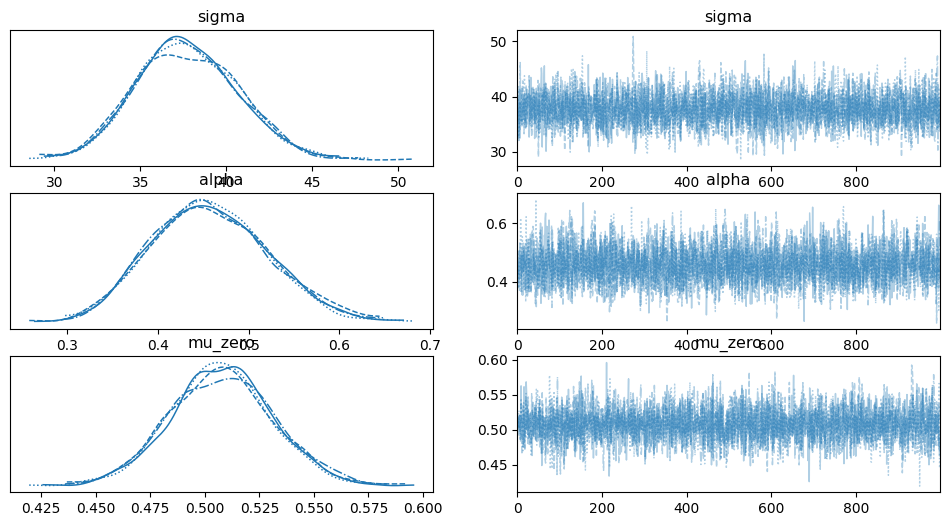

In [80]:
az.plot_trace(idata2, var_names=["sigma", "alpha", "mu_zero"])

Everything looks good, so we can move on to making our posterior checks:

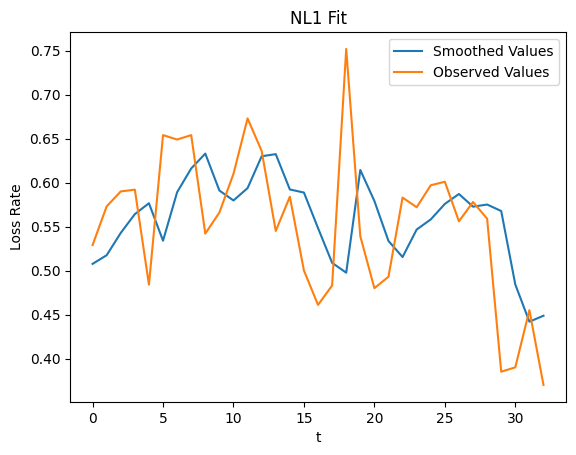

In [82]:
mu = az.extract(idata2, var_names=["mu"]).mean(axis=1)

plt.plot(mu[: data_idx[0]].values)
plt.plot(df2["NL1"].drop_nulls())
plt.xlabel("t")
plt.ylabel("Loss Rate")
plt.title("NL1 Fit")
plt.legend(["Smoothed Values", "Observed Values"])

<Axes: xlabel='ys / ys_hat'>

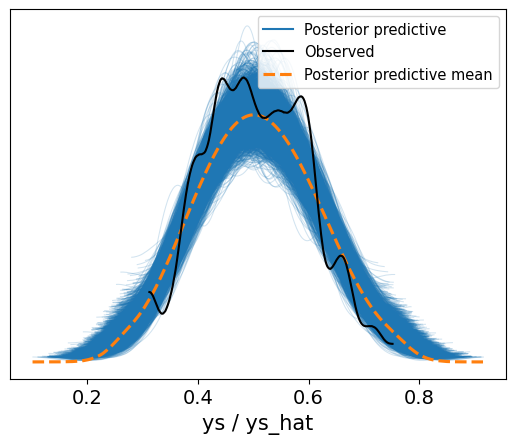

In [83]:
az.plot_ppc(
    idata2,
    data_pairs={"ys": "ys_hat"}
)

We can see here that again we are fitting the data as we were before.

One interesting difference in the fit between this model and the previous are the values of the smoothing parameter $\alpha$

Text(0.5, 0, 'Alpha Value')

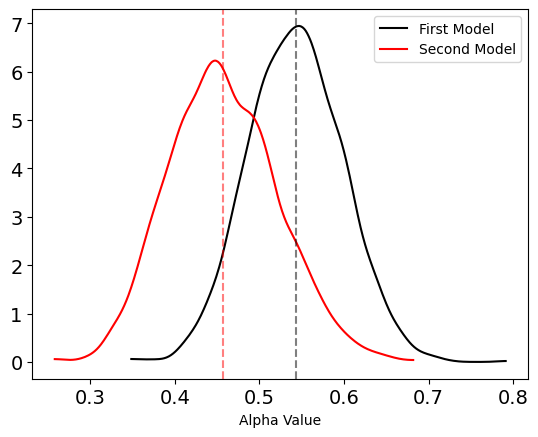

In [101]:
alpha1 = az.extract(idata, var_names=["alpha"])
alpha2 = az.extract(idata2, var_names=["alpha"])

az.plot_dist(alpha1, color="black", label="First Model")
az.plot_dist(alpha2, color="red", label="Second Model")
plt.axvline(alpha1.mean(), color="black", linestyle="dashed", alpha=0.5)
plt.axvline(alpha2.mean(), color="red", linestyle="dashed", alpha=0.5)
plt.xlabel("Alpha Value")

We can see that the second model has a mean value for $\alpha$ that is smaller than for the first model, which implies that less weight is put on lagged observations and more weight is put on lagged smoothed values in the second model. This results in more smoothing overall compared to the first model. This is somewhat intuitive because our effective sample size is smaller in the second model because we have fewer observations for each team and varying numbers of them, so we get a nice bit of regularization here because the model selects a slightly more aggressive smoothing parameter.

# Conclusion

This was a small proof-of-concept to firstly provide an actual implementation of the exponential smoothing model presented in Mahler (1990), as well as provide the extension to the case where we have a heterogeneously observed sample which is very common in real insurance datasets. I think exponential smoothing models are a conceptually elegant way to handle time-series prediction problems like this because it implicitly chooses how many lagged values are relevant, in a sense, as compared to a standard autoregressive model where the number of lags to include is effectively a hyperparameter. This model can also be easily extended to incorporate exogenous variables, time-varying variances, a hierarchical model to allow parameters to vary by individual, etcetera.

# References

Mahler, H. C. (1990). An Example of Credibility and Shifting Risk Parameters. Proceedings of the Casualty Actuarial Society, LXXX, 225–308. 